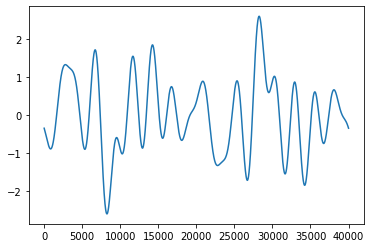

In [9]:
from Systems import TestStateSystem

import deepSI
from matplotlib import pyplot as plt

u = deepSI.deepSI.exp_design.multisine(40000, pmax=21)
plt.plot(u)

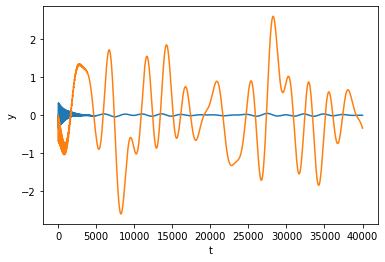

In [10]:
sys = TestStateSystem()
data = sys.apply_experiment(deepSI.System_data(u=u))
data.plot()

In [12]:
from torch import nn
class I_encoder(deepSI.fit_systems.SS_encoder):
    def __init__(self, nx = 2, na=2, nb=2, feedthrough=False) -> None:
        super().__init__(nx=nx, na=na, nb=nb, feedthrough=feedthrough)

    def init_nets(self, nu, ny): # a bit weird
        ny = ny if ny is not None else 1
        nu = nu if nu is not None else 1
        self.encoder = self.e_net(self.nb*nu+self.na*ny, self.nx, n_nodes_per_layer=self.e_n_nodes_per_layer, n_hidden_layers=self.e_n_hidden_layers, activation=self.e_activation)
        self.fn =      self.f_net(self.nx+nu,            self.nx, n_nodes_per_layer=self.f_n_nodes_per_layer, n_hidden_layers=self.f_n_hidden_layers, activation=self.f_activation)
        hn_in = self.nx + nu if self.feedthrough else self.nx
        self.hn =      nn.Identity(hn_in)#self.h_net(hn_in     ,            ny,      n_nodes_per_layer=self.h_n_nodes_per_layer, n_hidden_layers=self.h_n_hidden_layers, activation=self.h_activation)

In [13]:
I_enc = I_encoder(nx=2, na=2, nb=2, feedthrough=False)
train, test = data.train_test_split(split_fraction=0.2)
train, val  = train.train_test_split(split_fraction=0.25)

I_enc.fit(train_sys_data=train, val_sys_data=val, epochs=10, batch_size=256, loss_kwargs={'nf':50})

Initilizing the model and optimizer
Size of the training array =  28.5 MB
N_training_samples = 23949, batch_size = 256, N_batch_updates_per_epoch = 93
Initial Validation sim-NRMS= 1.2152925097081282


  0%|          | 0/10 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 0.5614287143863271
Epoch    1, sqrt loss  0.7327, Val sim-NRMS 0.5614, Time Loss: 77.0%, data: 0.5%, val: 22.5%, 13.5 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.5402317263310417
Epoch    2, sqrt loss  0.6933, Val sim-NRMS 0.5402, Time Loss: 75.6%, data: 0.5%, val: 23.9%, 12.9 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.5100467508880727
Epoch    3, sqrt loss  0.6787, Val sim-NRMS   0.51, Time Loss: 77.9%, data: 0.7%, val: 21.3%, 12.6 batches/sec
Epoch    4, sqrt loss  0.6558, Val sim-NRMS 0.5621, Time Loss: 78.7%, data: 0.7%, val: 20.6%, 12.7 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.5005731562043071
Epoch    5, sqrt loss  0.6458, Val sim-NRMS 0.5006, Time Loss: 78.3%, data: 0.7%, val: 21.0%, 13.4 batches/sec
Epoch    6, sqrt loss  0.6464, Val sim-NRMS 0.5615, Time Loss: 78.5%, data: 0.7%, val: 20

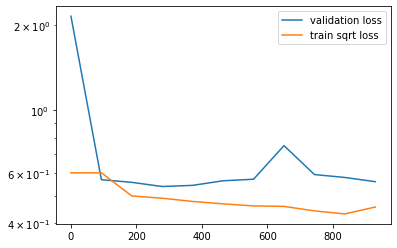

In [6]:
I_enc.checkpoint_load_system('_last')
plt.semilogy(I_enc.batch_id,I_enc.Loss_val,label='validation loss')
plt.semilogy(I_enc.batch_id,I_enc.Loss_train,label='train sqrt loss')
plt.legend()

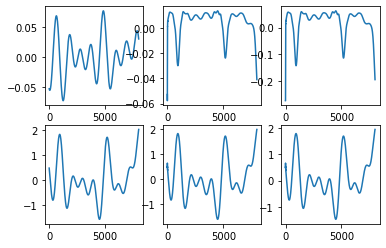

In [8]:
test_ss_enc = I_enc.apply_experiment(test,save_state=True)
X = test_ss_enc.x

plt.subplot(2,3,1)
plt.plot(test.y[:,0])
plt.subplot(2,3,2)
plt.plot(test_ss_enc.y[:,0])
plt.subplot(2,3,3)
plt.plot(X[:,0])

plt.subplot(2,3,4)
plt.plot(test.y[:,1])
plt.subplot(2,3,5)
plt.plot(test_ss_enc.y[:,1])
plt.subplot(2,3,6)
plt.plot(X[:,1])